# CBF Tutorial - Part 2
## Dynamic Obstacles
### Authors: Bardh, Tom and Shakiba

### The next example shows how we can use CBFs to navigate around dynamic obstacles. 

Again we start with the **nimble_ant** system, which has the following dynamics: 

\begin{align*}
  \dot{xr} = u = \begin{bmatrix}u_0 \\ u_1\end{bmatrix} \tag{1}\\
\end{align*}

Given an initial position $x^{init}$, our goal is to control this system to a goal location $xr^{goal}$.
\begin{align*}
xr^{init} = \begin{bmatrix} xr^{init}_0 \\  xr^{init}_1 \end{bmatrix} \qquad	xr^{goal} = \begin{bmatrix} xr^{goal}_0 \\  xr^{goal}_1 \end{bmatrix} \tag{2}\\
\end{align*}

However, different from our last example, the obstacles are dynamic. That means that our CBF depends not only on the dynamics of the system, but the obstacles as well. Recall our definition of the Barrier Function: 

\begin{align}
\dot{B}(x) \ge -\alpha\cdot(B(x)) 
\end{align}

In this case, the barrier function is defined as follows: 

\begin{align*}
B(xr,xo) = \frac{(xr_0-xo_0)^2}{a^2} + \frac{(xr_1-xo_1)^2}{b^2} - 1
\end{align*}

To obtain the derivative, we utilize multivariate chain rule:

\begin{align*}
\dot{B}(xr,xo) = \frac{\partial B}{\partial xr} * \dot{xr} + \frac{\partial B}{\partial xo} * \dot{xo}
\end{align*}

this is equivalent to

\begin{align*}
\dot{B}(xr,xo) = \begin{bmatrix} \frac{2}{a^2} (xr_0 - xo_0) \\  \frac{2}{b^2} (xr_1 - xo_1) \end{bmatrix} * \dot{xr} + 
\begin{bmatrix} \frac{2}{a^2} (xo_0 - xr_0) \\  \frac{2}{b^2} (xo_1 - xr_1) \end{bmatrix} * \dot{xo}
\end{align*}

here, $\dot{xr}$ is our control input and lets consider an example where the obstacle moves only left. That is $\dot{xo} = \begin{bmatrix} -1 \\  0 \end{bmatrix}$. 

\begin{align*}
\dot{B}(xr,xo) = \begin{bmatrix} \frac{2}{a^2} (xr_0 - xo_0) \\  \frac{2}{b^2} (xr_1 - xo_1) \end{bmatrix} * \begin{bmatrix}u_0 \\ u_1\end{bmatrix} + 
\begin{bmatrix} \frac{2}{a^2} (xo_0 - xr_0) \\  \frac{2}{b^2} (xo_1 - xr_1) \end{bmatrix} * \begin{bmatrix}-1 \\ 0\end{bmatrix}
\end{align*}

To make our implementation easier, we can also represent this in an augmented state 

\begin{align*}
x = \begin{bmatrix} xr_0 \\  xr_1 \\ xo_0 \\ xo_1 \end{bmatrix} 
\end{align*}

And in this case

\begin{align*}
\dot{B}(x) = \begin{bmatrix} \frac{2}{a^2} (xr_0 - xo_0) \\  \frac{2}{b^2} (xr_1 - xo_1) \\ \frac{2}{a^2} (xo_0 - xr_0) \\  \frac{2}{b^2} (xo_1 - xr_1) \end{bmatrix} * \begin{bmatrix}u_0 \\ u_1 \\ -1 \\ 0\end{bmatrix}
\end{align*}

Now, we solve the following quadratic program

\begin{align*}
\min_{u} \quad & ||u_{ref} - u||\\
\textrm{s.t.} \quad & \begin{bmatrix} \frac{2}{a^2} (xr_0 - xo_0) \\  \frac{2}{b^2} (xr_1 - xo_1) \\ \frac{2}{a^2} (xo_0 - xr_0) \\  \frac{2}{b^2} (xo_1 - xr_1) \end{bmatrix} * \begin{bmatrix}u_0 \\ u_1 \\ -1 \\ 0\end{bmatrix} \dot{x} \ge -(\frac{(xr_0-xo_0)^2}{a^2} + \frac{(xr_1-xo_1)^2}{b^2} - 1) \\
\tag{12}
\end{align*}

We can pose this a quadratic program. 

\begin{align*}
\min_{\mathbf{x}} \quad & \frac{1}{2}\mathbf{x}^T P\mathbf{x} + q^T\mathbf{x} \\
\textrm{s.t.} \quad & G\mathbf{x} \le h \\
\quad & A\mathbf{x} = b \tag{13}
\end{align*}

In our case, $\mathbf{x} = \dot{x}$ is the decision variable, 
Where

$ P = I_4 \tag{14}$
$ q = \begin{bmatrix} -u_{ref0} \\  -u_{ref1} \\ 0 \\ 0 \end{bmatrix} \tag{15}$
$ G = \begin{bmatrix} \frac{2}{a^2} (xr_0 - xo_0) \\  \frac{2}{b^2} (xr_1 - xo_1) \\ \frac{2}{a^2} (xo_0 - xr_0) \\  \frac{2}{b^2} (xo_1 - xr_1) \end{bmatrix} \tag{16}$
$ h = (\frac{(xr_0-xo_0)^2}{a^2} + \frac{(xr_1-xo_1)^2}{b^2} - 1) \tag{17}$


Lets consider an example where our nimble ant system starts at position $xr = \begin{bmatrix} 0 \\  3.2 \end{bmatrix}$ and an obstacle starts at postion $xo = \begin{bmatrix} xo_0 \\  xo_1 \end{bmatrix} = \begin{bmatrix} 10 \\  3.5 \end{bmatrix}$.



In [90]:
from sympy import symbols
import numpy as np
import matplotlib.pyplot as plt
import control as control
import cvxopt as cvxopt
from cbflib import cbf, cbf_utils, sys_and_ctrl
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from IPython.display import HTML

In [91]:
# Robot Goal
x_goal = np.array([10, 3.5])

# Elipse format (x,y,rad_x,rad_y)
bad_sets = cbf_utils.example(4)

# Parameters for reference controller
ctrl_param_k = [0.3, 0.3]

# Symbols and equations for the CBF
xr_0, xr_1, xo_0, xo_1, a, b = symbols('xr_0 xr_1 xo_0 xo_1 a b')
symbs = (xr_0, xr_1, xo_0, xo_1, a, b)
B = ((xr_0 - xo_0)/a)**2 + ((xr_1 - xo_1)/b)**2 - 1

# ! placeholders for more complex functions
f, g = 1, 1


In [92]:
# Initialize CBF
# my_CBF = cbf.CBF(B=B, f=f, g=g, states=(xr_0, xr_1), agent_states=(xo_0, xo_1), bad_sets=bad_sets, symbs=symbs)
my_CBF = cbf.CBF(B=B, f=f, g=g, states=(
    xr_0, xr_1, xo_0, xo_1), bad_sets=bad_sets, symbs=symbs)

# Simulation settings
T_max = 20
n_samples = 200
T = np.linspace(0, T_max, n_samples)

# System definition using the control toolbox
nimble_ant_with_agent_sys = control.NonlinearIOSystem(
    sys_and_ctrl.nimble_ant_with_agent_f, None , inputs=('u_0', 'u_1'), outputs=('xr_0', 'xr_1', 'xo_0', 'xo_1'), dt=None,
    states=('xr_0', 'xr_1', 'xo_0', 'xo_1'), name='nimble_ant_with_agent_sys')

nimble_ant_with_agent_ctrl = control.NonlinearIOSystem(
    None, sys_and_ctrl.nimble_ant_with_agent_c, inputs=('xr_0', 'xr_1', 'xo_0', 'xo_1'), outputs=('u_0', 'u_1'), dt=None,
    name='nimble_ant_with_agent_ctrl', params={'x_goal': x_goal, 'bad_sets': bad_sets, 'ctrl_param_k': ctrl_param_k, 'CBF': my_CBF})

nimble_ant_closed = control.InterconnectedSystem(
    (nimble_ant_with_agent_sys, nimble_ant_with_agent_ctrl),       # systems
    connections=(
        ('nimble_ant_with_agent_sys.u_0', 'nimble_ant_with_agent_ctrl.u_0'),
        ('nimble_ant_with_agent_sys.u_1', 'nimble_ant_with_agent_ctrl.u_1'),
        ('nimble_ant_with_agent_ctrl.xr_0', 'nimble_ant_with_agent_sys.xr_0'),
        ('nimble_ant_with_agent_ctrl.xr_1', 'nimble_ant_with_agent_sys.xr_1'),
        ('nimble_ant_with_agent_ctrl.xo_0', 'nimble_ant_with_agent_sys.xo_0'),
        ('nimble_ant_with_agent_ctrl.xo_1', 'nimble_ant_with_agent_sys.xo_1')
    ),
    #   inplist=None,
    outlist=('nimble_ant_with_agent_sys.xr_0', 'nimble_ant_with_agent_sys.xr_1',
             'nimble_ant_with_agent_sys.xo_0', 'nimble_ant_with_agent_sys.xo_1'),
    states=('xr_0', 'xr_1', 'xo_0', 'xo_1')
)

In [93]:

# Initial conditions
# min, max of x,y values for initial conditions
min_x, min_y, max_x, max_y = 0, 0, 0.5, 0.5

# number of initial conditions in each axis
nx, ny = 3, 3

# Vectors of initial conditions in each axis
xx = np.linspace(min_x, max_x, nx)
yy = np.linspace(min_y, max_y, ny)

# Uncomment the following for specific intial conditions
xx = [0]
yy = [3.2]

# Disable cvxopt optimiztaion output
cvxopt.solvers.options['show_progress'] = False
cvxopt.solvers.options['max_iter'] = 1000

# Loop through initial conditions and simulate system
print('Computing trajectories for initial conditions:')
print('x_0\t x_1')
for idxi, i in enumerate(xx):
    for idxj, j in enumerate(yy):
        # If initial condition is inside the bad set, skip it.
        bool_val = 0
        curr_bs = []
        for idxk, k in enumerate(bad_sets):
            curr_bs = bad_sets[idxk]
            if cbf_utils.is_inside_ellipse([i, j], bad_sets[idxk]):
                print('Skip (Invalid):\t', i, j)
                bool_val = 1
        if bool_val == 1:
            continue

        print(round(i, 2), '\t', round(j, 2), "\t... ", end="", flush=True)
        xr_0 = np.array([i, j])

        # Compute output on the nimble ant system for given initial conditions and timesteps T
        t, y, x = control.input_output_response(sys=nimble_ant_closed, T=T, U=0, X0=[
                                                i, j, 10, 3.5], return_x=True, method='BDF')

        print("Done")

Computing trajectories for initial conditions:
x_0	 x_1
0 	 3.2 	... Done


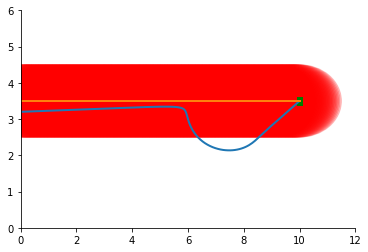

In [94]:
# Plot
fig, ax = plt.subplots()
jet = plt.get_cmap('jet')
colors = iter(jet(np.linspace(0, 1, len(xx)*len(yy))))
plt.xlim(0, 12)
plt.ylim(0, 6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)

def animate(i):
    ims = []
    line1.set_data((x[0][0:i], x[1][0:i]))
    line2.set_data((x[2][0:i], x[3][0:i]))
    ell = Ellipse((x[2][i-1], x[3][i-1]),
                      bad_sets[0][2], bad_sets[0][3], color='r', alpha=0.2)
    patchObs = ax.add_patch(ell)
    ims.append(line1)
    ims.append(line2)
    ims.append(patchObs)
    goal_square = plt.Rectangle(
        x_goal-np.array([.1, .1]), .2, .2, color='g', alpha=0.5)
    patchGoal = ax.add_patch(goal_square)
    ims.append(patchGoal)
    return ims

ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, frames=n_samples)

#! NOTE: FFmpeg is required to run the animation in a jupyter notebook. This is not needed if the code is executed in as a python script.
plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg.exe"
HTML(ani.to_html5_video())


